# Investigating the Raw Data

## Imports

For this initial discovery and investigation, we'll
need to start off with a lot of imports. We'll use the
steps in this notebook to bring in, investigate, and
translate the raw data from mtgjson files into a format
that can be more easily used throughout the rest of the
project.

In [1]:
import gc
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import cv2

#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from nltk.corpus import stopwords

from _code.card_selection import card_sampler, \
            plot_card_trends, card_imager, \
                synthesize_names

from _code.cleaner import preprocess

from _code.viz import showImagesHorizontally, word_plot

from _code import card_selection as FUNC_TESTING

from IPython.display import Image

<!-- Need to create a translator from price data to real data
using a different all cards set. Main db is scryfall but
pricing data comes from mtgjson.com -->

We'll start off by bringing in the data for all of the
cards from mtgjson so that we can create a translator
for the related pricing information so it can be used
in conjunction with the scryfall data, which we'll
import later.

In [2]:
trans_df = pd.read_json('./data/AllPrintings.json')

The mtgjson data has a 'meta' property that we can
ignore, so we'll drop the column and rows that are
exclusive to it.

In [3]:
trans_df

,meta,data
date,2023-04-27,NaN
version,5.2.1+20230427,NaN
10E,NaN,"{'baseSetSize': 383, 'block': 'Core Set', 'boo..."
2ED,NaN,"{'baseSetSize': 302, 'block': 'Core Set', 'boo..."
2X2,NaN,"{'baseSetSize': 577, 'booster': {'collector': ..."
...,...,...
YSNC,NaN,"{'baseSetSize': 30, 'block': 'Alchemy 2022', '..."
ZEN,NaN,"{'baseSetSize': 249, 'block': 'Zendikar', 'boo..."
ZNC,NaN,"{'baseSetSize': 1, 'block': 'Commander', 'card..."
ZNE,NaN,"{'baseSetSize': 30, 'cards': [{'artist': 'Adam..."


In [4]:
trans_df.drop(columns='meta',inplace=True)

# the set March of the Machines was still in preview
# when this data was initially collected. We'll drop
# the entries from this set here.
trans_df.drop(['MOM','FMOM'],inplace=True)
# 'FMOM' is specific to the face cards for the
# jumpstart set
trans_df.dropna(inplace=True)
display(
    trans_df.head(),
    trans_df.info
    )

,data
10E,"{'baseSetSize': 383, 'block': 'Core Set', 'boo..."
2ED,"{'baseSetSize': 302, 'block': 'Core Set', 'boo..."
2X2,"{'baseSetSize': 577, 'booster': {'collector': ..."
2XM,"{'baseSetSize': 332, 'booster': {'default': {'..."
30A,"{'baseSetSize': 594, 'booster': {'default': {'..."


<bound method DataFrame.info of                                                    data
10E   {'baseSetSize': 383, 'block': 'Core Set', 'boo...
2ED   {'baseSetSize': 302, 'block': 'Core Set', 'boo...
2X2   {'baseSetSize': 577, 'booster': {'collector': ...
2XM   {'baseSetSize': 332, 'booster': {'default': {'...
30A   {'baseSetSize': 594, 'booster': {'default': {'...
...                                                 ...
YSNC  {'baseSetSize': 30, 'block': 'Alchemy 2022', '...
ZEN   {'baseSetSize': 249, 'block': 'Zendikar', 'boo...
ZNC   {'baseSetSize': 1, 'block': 'Commander', 'card...
ZNE   {'baseSetSize': 30, 'cards': [{'artist': 'Adam...
ZNR   {'baseSetSize': 280, 'booster': {'arena': {'bo...

[693 rows x 1 columns]>

This is a dataset of ever sigle set that has been
released. This will need to be iterated through to get
every single card that has been released in each
printing.  

The only information of concern is the uuid and the
scryfall id since we're only using this to get the
pricing data converted into a format that can be
attached to the scryfall imports.

We can delete the trans_df variable after this.

In [5]:
trans_df['data'].loc['10E']['cards'][0].keys()

dict_keys(['artist', 'availability', 'boosterTypes', 'borderColor', 'colorIdentity', 'colors', 'convertedManaCost', 'edhrecRank', 'edhrecSaltiness', 'finishes', 'foreignData', 'frameVersion', 'hasFoil', 'hasNonFoil', 'identifiers', 'isReprint', 'keywords', 'language', 'layout', 'legalities', 'manaCost', 'manaValue', 'name', 'number', 'originalText', 'originalType', 'power', 'printings', 'purchaseUrls', 'rarity', 'rulings', 'setCode', 'subtypes', 'supertypes', 'text', 'toughness', 'type', 'types', 'uuid', 'variations'])

In [6]:
id_mixer = []

Here, we can create a translation data set that
includes the scryfall ID, universal ID, the name, and
the set that the card is from.

In [7]:
for _set in trans_df['data'].index:
    for card in trans_df['data'].loc[_set]['cards']:
        id_mixer.append(
                        {
                            'scryfall': card['identifiers']['scryfallId'],
                            'uuid':     card['uuid'],
                            'name':     card['name'],
                            'set':      _set
                        })

In [8]:
id_mixer[:5]

[{'scryfall': '7a5cd03c-4227-4551-aa4b-7d119f0468b5',
  'uuid': '5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c',
  'name': "Ancestor's Chosen",
  'set': '10E'},
 {'scryfall': '82072a1d-c1ab-4b4f-875f-d0591447e0a4',
  'uuid': 'b7c19924-b4bf-56fc-aa73-f586e940bd42',
  'name': "Ancestor's Chosen",
  'set': '10E'},
 {'scryfall': '8f7980d4-da43-4d6d-ad16-14b8a34ae91d',
  'uuid': '57aaebc1-850c-503d-9f6e-bb8d00d8bf7c',
  'name': 'Angel of Mercy',
  'set': '10E'},
 {'scryfall': 'b0157252-6949-4f03-a15c-c168512123a8',
  'uuid': '8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a',
  'name': 'Angel of Mercy',
  'set': '10E'},
 {'scryfall': 'a285aa3f-bcfb-4fc3-8441-85a56c72a3e4',
  'uuid': '55bd38ca-dc73-5c06-8f80-a6ddd2f44382',
  'name': 'Angelic Blessing',
  'set': '10E'}]

In [9]:
# Convert id_mixer to a dataframe to merge the cards
id_mixer_df = pd.DataFrame(id_mixer)
del id_mixer
gc.collect()

0

In [10]:
id_mixer_df

,scryfall,uuid,name,set
0,7a5cd03c-4227-4551-aa4b-7d119f0468b5,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c,Ancestor's Chosen,10E
1,82072a1d-c1ab-4b4f-875f-d0591447e0a4,b7c19924-b4bf-56fc-aa73-f586e940bd42,Ancestor's Chosen,10E
2,8f7980d4-da43-4d6d-ad16-14b8a34ae91d,57aaebc1-850c-503d-9f6e-bb8d00d8bf7c,Angel of Mercy,10E
3,b0157252-6949-4f03-a15c-c168512123a8,8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a,Angel of Mercy,10E
4,a285aa3f-bcfb-4fc3-8441-85a56c72a3e4,55bd38ca-dc73-5c06-8f80-a6ddd2f44382,Angelic Blessing,10E
...,...,...,...,...
79942,a3c2c3d7-3437-44b8-8d39-d3abe02af50e,3f492516-7767-5ed7-a1d4-e3f7c06aee2f,Into the Roil,ZNR
79943,f7be5c0a-b538-4bc5-89c7-f5a81de7ccc3,3f9a0369-5fe7-5aee-85fe-3cfaacd275af,Bloodchief's Thirst,ZNR
79944,560c02ec-f21e-405b-8267-7f7ff089904a,97577e9e-69a9-5a8b-9c24-a72703790046,Roil Eruption,ZNR
79945,5fa531b2-ccd5-489b-9edf-4cab01aca7fd,deb51cbd-b890-5b2d-9d6f-7b896e16c6fd,Roiling Regrowth,ZNR


Now, we can import the prices data and investigate it,
additionally we can go straight from this to applying
it all to the scryfall data frame.

In [11]:
all_prices = pd.read_json('./data/AllPrices.json')

Here, we'll check the number of unique values across
all of our data frames to make sure the numbers make
sense.

In [12]:
len(all_prices),\
len(id_mixer_df['scryfall'].unique()), \
len(id_mixer_df['uuid'].unique())

(80095, 78639, 79947)

it looks like there may be duplicates of the scryfall
ids within the uuids, we'll have to check what those
are. It looks like scryfall has the lowest count here,
so it likely maps to multiple printings of the cards
in the universe ID and the price ids.

In [13]:
id_mixer_df['scryfall'].value_counts()

scryfall
fea4a077-718b-44af-87be-90df61aab643    5
8987644d-5a31-4a4e-9a8a-3d6260ed0fd6    5
097165ee-f959-49e3-a5c1-f78043e538d9    3
25d09421-08d5-4ca9-8937-5f937bc9c929    3
d20738d2-a159-4e3e-be7a-561a121bd447    2
                                       ..
6fa863a1-8d36-424d-bb65-8e0424617769    1
12604a80-d803-4598-b2b6-345c47fe9af6    1
4680a8da-69bd-4dc9-b7b0-e15d9488a8d5    1
bcdc3fb1-667e-49d7-b677-b70e6e217f4f    1
cbef1409-4e7c-445e-ae6b-b3133faf1f73    1
Name: count, Length: 78639, dtype: int64

We have several cards with more than 1 result, let's
take a look at those.

In [14]:
counts = pd.DataFrame(id_mixer_df['scryfall'].value_counts().rename('counts'))
counts

,counts
scryfall,
fea4a077-718b-44af-87be-90df61aab643,5
8987644d-5a31-4a4e-9a8a-3d6260ed0fd6,5
097165ee-f959-49e3-a5c1-f78043e538d9,3
25d09421-08d5-4ca9-8937-5f937bc9c929,3
d20738d2-a159-4e3e-be7a-561a121bd447,2
...,...
6fa863a1-8d36-424d-bb65-8e0424617769,1
12604a80-d803-4598-b2b6-345c47fe9af6,1
4680a8da-69bd-4dc9-b7b0-e15d9488a8d5,1


In [15]:
counted_mixer = id_mixer_df.merge(
    counts,
    left_on='scryfall',
    right_index=True,
    how='left'
)
del counts
gc.collect()

0

In [16]:
duplicates = counted_mixer[counted_mixer['counts'] > 1]
duplicates

,scryfall,uuid,name,set,counts
7665,d6fc6ed9-740a-4726-8f2c-5d662636f687,a7c38e21-6688-54a6-ae77-ced41669abe9,Realm-Cloaked Giant // Cast Off,AFC,2
7666,d6fc6ed9-740a-4726-8f2c-5d662636f687,131f4174-02e8-5435-ad81-e90fc1b849cb,Realm-Cloaked Giant // Cast Off,AFC,2
8579,937dbc51-b589-4237-9fce-ea5c757f7c48,f9f10d34-071c-57a6-b58c-7553abad5c20,Dusk // Dawn,AKH,2
8580,937dbc51-b589-4237-9fce-ea5c757f7c48,87f0062a-8321-5c16-960e-a12ce1df5839,Dusk // Dawn,AKH,2
8581,06c9e2e8-2b4c-4087-9141-6aa25a506626,71a0621f-32a6-5450-8ad8-6cdae505cf59,Commit // Memory,AKH,2
...,...,...,...,...,...
79907,243d374f-5b40-4cff-99f5-079ba873d44b,bb2109b7-8ecf-558e-829f-cc2b455634ab,"Shatterskull Smashing // Shatterskull, the Ham...",ZNR,2
79908,a156b510-8879-4a7b-b15b-71374cb1e6f7,90a8dcab-fe91-579e-bb10-55c67f9c5f4a,Valakut Awakening // Valakut Stoneforge,ZNR,2
79909,a156b510-8879-4a7b-b15b-71374cb1e6f7,518f1b89-f077-5315-a6b6-c7ae28f50035,Valakut Awakening // Valakut Stoneforge,ZNR,2
79918,90df87c1-59df-4244-8653-15e7f13cdacc,f6aeb170-0112-5224-8df5-274ce7558327,"Turntimber Symbiosis // Turntimber, Serpentine...",ZNR,2


Verifying that the counts are the same for all
differences and there were no resulting nas

In [17]:
counted_mixer['counts'].isna().sum()

0

Making sure that the number of duplicates we found is
the same as the number of duplicates across the data
frame.

In [18]:
counted_mixer['scryfall'].shape[0]-counted_mixer['scryfall'].nunique(),\
    len(duplicates) - duplicates['scryfall'].nunique()

(1308, 1308)

For simplicity, we'll go ahead and pull in the scryfall
database now so we can do verifications on the data and
check what's going on with the duplicates.

In [19]:
all_cards = pd.read_json('./data/all-cards-20230425091645.json')

We'll go ahead and reduce all_cards down to just the
columns we need. These column names were obtained
through a .columns investigation on the dataframe.

In [20]:
used_columns = [
    # 'object',
    'id',
    'oracle_id',
    # 'multiverse_ids',
    # 'mtgo_id',
    # 'mtgo_foil_id',
    'tcgplayer_id',
    # 'cardmarket_id',
    'name',
    'lang',             # <= reduce this to english, not
                        # going to be representative at
                        # scale but will reduce the data
                        # for legibility 

    'released_at',
    # 'uri',
    # 'scryfall_uri',
    'layout',           # <= determines frame, need to drop:
                        # token, emblem, scheme, vanguard
                        #  
    # 'highres_image',
    # 'image_status',
    'image_uris',       # <= will reference this in
                        # IPython.display later 

    'mana_cost',
    'cmc',
    'type_line',
    'oracle_text',      # <= going to use NLP on this
                        # to get what the card does in
                        # a programmatic way 

    'power',
    'toughness',
    'colors',
    'color_identity',
    'keywords',
    'legalities',       # <= need to convert this into
                        # dummied columns 

    'games',            # <= limit to 'paper' then drop

    'reserved',         # <= need to determine if this
                        # is going to be used as an
                        # influence or not, meta-
                        # knowledge says that it is 

    'foil',
    'nonfoil',
    # 'finishes',         # <= this is likely determined
                        # by the foil and nonfoil column

    'oversized',        # <= need to drop where True, 
                        # then drop the column itself 
    'promo',
    'reprint',
    'variation',
    'set_id',
    'set',
    # 'set_name',         # <= have other ways to match
                        # set data

    'set_type',
    # 'set_uri',
    # 'set_search_uri',
    # 'scryfall_set_uri',
    # 'rulings_uri',
    # 'prints_search_uri',
    # 'collector_number',
    # 'digital',
    'rarity',
    # 'flavor_text',
    # 'card_back_id',
    # 'artist',
    # 'artist_ids',
    # 'illustration_id',
    'border_color',     # <= remove silver and gold-
                        # border cards then drop
    # 'frame',
    'full_art',
    'textless',
    # 'booster',
    # 'story_spotlight',
    'edhrec_rank',
    # 'penny_rank',
    # 'prices',           # <= we'll use the prices from
                        # the other data set instead of
                        # this one 
    'related_uris',
    # 'printed_name',
    # 'printed_type_line',
    # 'printed_text',
    # 'security_stamp',
    # 'all_parts',
    'promo_types',
    # 'arena_id',
    'loyalty',
    # 'watermark',
    # 'frame_effects',
    # 'preview',
    'produced_mana',            # <= may not make it into
                                # the final model since
                                # the text should also
                                # have this

    # 'card_faces',               # <= probably don't need
                                # this since cards are
                                # always listed as both
                                # faces 
    # 'color_indicator',          # <= an extra part of
                                # color identity
    # 'tcgplayer_etched_id',      # <= id for etched card
                                # on tcgplayer

    # 'content_warning',          # <= 'illegal' cards
    # 'attraction_lights',        # <= is part of unset
                                # mechanics
    'variation_of',
    # 'life_modifier',          # part of vanguard
    # 'hand_modifier',          # """"""
    # 'flavor_name'             # <= redundant of name
                                # on cards that are
                                # nickname cards 
]

In [21]:
all_cards = all_cards[used_columns]

In [22]:
all_cards.head()

,id,oracle_id,tcgplayer_id,name,lang,released_at,layout,image_uris,mana_cost,cmc,...,rarity,border_color,full_art,textless,edhrec_rank,related_uris,promo_types,loyalty,produced_mana,variation_of
0,0000579f-7b35-4ed3-b44c-db2a538066fe,44623693-51d6-49ad-8cd7-140505caf02f,14240.0,Fury Sliver,en,2006-10-06,normal,{'small': 'https://cards.scryfall.io/small/fro...,{5}{R},6.0,...,uncommon,black,False,False,6038.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
1,00006596-1166-4a79-8443-ca9f82e6db4e,8ae3562f-28b7-4462-96ed-be0cf7052ccc,33347.0,Kor Outfitter,en,2009-10-02,normal,{'small': 'https://cards.scryfall.io/small/fro...,{W}{W},2.0,...,common,black,False,False,15041.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
2,00009878-d086-46f0-a964-15734d8368ac,30cd69a8-7893-4075-94ca-04450ff821d3,NaN,Spirit of the Hearth,fr,2017-08-25,normal,{'small': 'https://cards.scryfall.io/small/fro...,{4}{W}{W},6.0,...,rare,black,False,False,9831.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
3,0000a54c-a511-4925-92dc-01b937f9afad,dc4e2134-f0c2-49aa-9ea3-ebf83af1445c,98659.0,Spirit,en,2015-05-22,token,{'small': 'https://cards.scryfall.io/small/fro...,,0.0,...,common,black,False,False,NaN,{'tcgplayer_infinite_articles': 'https://infin...,[setpromo],NaN,NaN,NaN
4,0000cd57-91fe-411f-b798-646e965eec37,9f0d82ae-38bf-45d8-8cda-982b6ead1d72,145764.0,Siren Lookout,en,2017-09-29,normal,{'small': 'https://cards.scryfall.io/small/fro...,{2}{U},3.0,...,common,black,False,False,13249.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN


We'll check the first card in the list against the
scryfall data.

In [23]:
duplicates['scryfall'].iloc[0]

'd6fc6ed9-740a-4726-8f2c-5d662636f687'

In [24]:
duplicate_card = all_cards[
    all_cards['id'] == duplicates['scryfall'].iloc[0]
    ]

348891    Realm-Cloaked Giant // Cast Off
Name: name, dtype: object


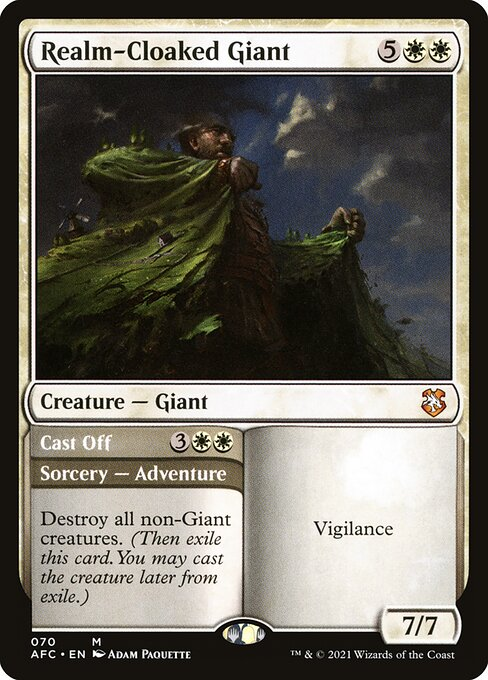

In [25]:
print(duplicate_card['name'])

# image uris have extra information at the end that is
# denoted by a ?, this needs to be stripped to be
# displayed properly 
Image(duplicate_card['image_uris'].iloc[0]['normal'].split('?')[0])

This is a card that has two names, generally these
cards are represented as "first name // second name" as
shown above (Realm-Cloaked Giant // Cast Off). Since
this card has two separate abilities that act as
different cards, it makes sense that this would have
more than one ID in some databases. We can safely
ignore this as long as the prices for both of the
halves are the same.  
But what about the entries that have _**FIVE**_ counts?

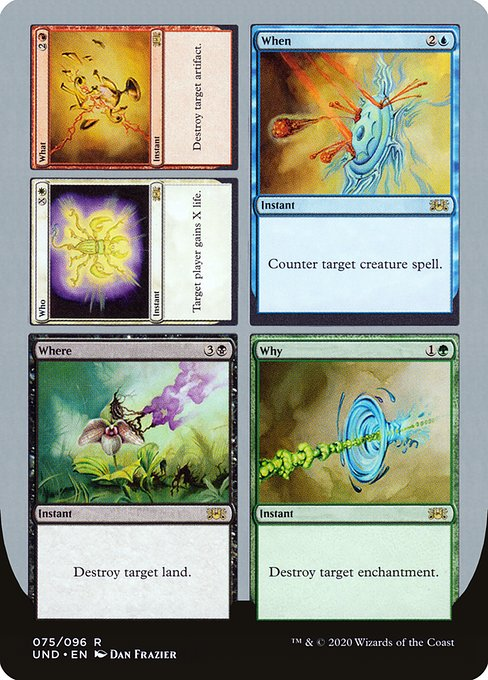

In [26]:
Image(all_cards[all_cards['id'] ==
    duplicates.sort_values('counts',ascending=False)['scryfall'].iloc[0]
    ]['image_uris'].iloc[0]['normal'].split('?')[0])

Ok, this is a joke card from one of Magic's "Un" sets.
This card isn't tournament-legal and also falls outside
of where we want to be looking anyway. We can go ahead
and reduce our main dataframe down to the cards we're
actually looking at and then reconfigure everything and
work on verifying the prices are all above board after.
This will prevent us from having to work on corner
cases that will take up a lot of time that isn't
strictly necessary.  
Let's go ahead and get rid of the meta information in
our all_prices dataframe first to make sure it isn't
forgotten.

In [27]:
all_prices = all_prices.drop(columns="meta").dropna()

We are going to look specifically at cards that are in
English, cards that are not oversized, cards that are
not tokens, emblems, schemes, or vanguards.

We'll print the shape out after each iteration to see
how many cards are remaining each time.

In [28]:
print(all_cards.shape)
# only looking at english cards
all_cards = all_cards[all_cards['lang'] == 'en']
print(all_cards.shape)
# only want playable cards
all_cards = all_cards[all_cards['oversized'] == False]
print(all_cards.shape)
# determines frame, need to drop: token, emblem, scheme, vanguard
all_cards = all_cards[
    (~all_cards['layout'].isin(['token','emblem','scheme','vanguard']))
    ]
print(all_cards.shape)
# reduce this to only cards thate are printed on paper
all_cards = all_cards[all_cards['games'].map(
                lambda x: 'paper' in x
            )]
print(all_cards.shape)
# strip out gold and silver border cards from the set
all_cards = all_cards[(all_cards['border_color'] != 'silver') &
                    (all_cards['border_color'] != 'gold')]
print(all_cards.shape)
# every card has a type line, if that's missing - the
# entry is broken. 
all_cards = all_cards[~all_cards['type_line'].isna()]
print(all_cards.shape)

###########################

cleaned_cards = all_cards.drop(columns=[
    'lang','oversized','layout','games','border_color'
])

print(cleaned_cards.shape)
del all_cards
gc.collect()

(415580, 39)
(80033, 39)
(79470, 39)
(77435, 39)
(69414, 39)
(67533, 39)
(67520, 39)
(67520, 34)


0

Our full cards dataset dropped down from 415,580 to
67,520 entries. Most of that drop was just in narrowing
the targets to English cards, taking it down to only
20% of the data set.

Unfortunately, pricing data on non-english cards is
mostly inconsistent, especially on TCGPlayer, which is
the primary pricing dataset we'll be observing in this.

Not-so-unfortunately, most of the other cards we've
removed are generally cards that either don't have much
value or sell so infrequently that the data isn't going
to be very good on them.

Now let's go back to the theory from before, that all
of the cards that have duplicate entries are cards that
have multiple items. We'll reduce duplicates down to
only the cards that exist in all_cards.

In [29]:
cleaned_cards['id']

0         0000579f-7b35-4ed3-b44c-db2a538066fe
1         00006596-1166-4a79-8443-ca9f82e6db4e
4         0000cd57-91fe-411f-b798-646e965eec37
6         00012bd8-ed68-4978-a22d-f450c8a6e048
17        0001f1ef-b957-4a55-b47f-14839cdbab6f
                          ...                 
415545    fff9989f-77a3-4f73-ade6-c04306c98501
415553    fffaa737-ce46-4f35-aa8c-bd9bb77ed9f6
415564    fffce2f7-b619-4483-a75e-916343194641
415568    fffe7b2b-22c3-4e6a-9b1b-c6d7b29b9f86
415572    ffff0825-9996-4ae5-90c8-cb976ccf4ae0
Name: id, Length: 67520, dtype: object

In [30]:
reduced_dupes = duplicates.merge(
    cleaned_cards['id'],
    left_on='scryfall',
    right_on='id',
    how='inner'
)
reduced_dupes.drop(columns='id',inplace=True)
reduced_dupes.isna().sum()

scryfall    0
uuid        0
name        0
set         0
counts      0
dtype: int64

In [31]:
scryfall_ids = reduced_dupes['scryfall'].unique()
unequal_cards = []
failed_cards  = []
for _sf_id in scryfall_ids:
    step='initializing scryfall id'
    _card_entry = reduced_dupes[reduced_dupes['scryfall'] == _sf_id]
    _check_ids = list(_card_entry['uuid'].values)
    try:
        _prices = {}
        _price_type = []
        step = f'pricing'
        for _id in _check_ids:
            _price_list = all_prices[
                all_prices.index == _id
            ]['data'].iloc[0]['paper']['tcgplayer']['retail']
            step=f"get price ... id: {_id}"
            _type = sorted(list(_price_list.keys()))[0]
            _price_type.append(_type)
            _prices[_id] = _price_list[_type]
        
        step = 'loading test'
        _price_test = [price for price in list(_prices.values())]
        step = 'check equal'
        is_equal = (sum(
            np.array(
                list(_price_test[0].values())
                ) - np.array(
                    list(_price_test[1].values()))
            )==0)
        if ~is_equal:
            step='unequal'
            for i, k in enumerate(_card_entry.index):
                unequal_cards.append(
                    {
                        'name':_card_entry.loc[k]['name'],
                        'uuid':_card_entry.loc[k]['uuid'],
                        'scryfall':_card_entry.loc[k]['scryfall'],
                        'prices':list(
                                _price_test[i].values()
                                ),
                        'price_type':_price_type[i]
                    }
                    )
    except:
        for i, k in enumerate(_card_entry.index):
                failed_cards.append(
                {
                    'name':_card_entry.loc[k]['name'],
                    'uuid':_card_entry.loc[k]['uuid'],
                    'scryfall':_card_entry.loc[k]['scryfall'],
                    'prices':list(
                            _price_test[i].values()
                            ),
                    'price_types':_price_type,
                    'failed_step':step
                }
        )
del reduced_dupes
del duplicates
del scryfall_ids
gc.collect()

0

Let's take a look at the cards left in the
unequal_cards set:

In [32]:
# unequal_cards = pd.DataFrame(unequal_cards)
# unequal_cards[['name','prices']].iloc[:2]['prices']
# this was being used for testing and finding issues in
# the separation of values from the previous cell. 
# These issues have been corrected.
# unequal_cards[['name','prices','price_type']] 
unequal_cards

[]

In [33]:
failed_cards = pd.DataFrame(failed_cards)
failed_cards[['name','prices','price_types','failed_step']]

,name,prices,price_types,failed_step
0,Struggle // Survive,"[0.19, 0.19, 0.19, 0.15, 0.15, 0.14, 0.14, 0.1...",[],pricing
1,Struggle // Survive,"[0.19, 0.19, 0.19, 0.15, 0.15, 0.14, 0.14, 0.1...",[],pricing
2,Collectigull // Only the Best,"[1.58, 1.55, 1.58, 1.55, 1.55, 1.55, 1.51, 1.5...",[],pricing
3,Collectigull // Only the Best,"[1.58, 1.55, 1.58, 1.55, 1.55, 1.55, 1.51, 1.5...",[],pricing
4,Champions of Archery // Join the Group,"[1.58, 1.55, 1.58, 1.55, 1.55, 1.55, 1.51, 1.5...",[],pricing
5,Champions of Archery // Join the Group,"[1.58, 1.55, 1.58, 1.55, 1.55, 1.55, 1.51, 1.5...",[],pricing
6,Nezumi Graverobber // Nighteyes the Desecrator,"[1.06, 1.04, 1.04, 1.04, 1.04, 1.04, 1.04, 1.0...",[],pricing
7,Nezumi Graverobber // Nighteyes the Desecrator,"[1.06, 1.04, 1.04, 1.04, 1.04, 1.04, 1.04, 1.0...",[],pricing
8,Nezumi Graverobber // Nighteyes the Desecrator,"[1.06, 1.04, 1.04, 1.04, 1.04, 1.04, 1.04, 1.0...",[],pricing
9,Nezumi Graverobber // Nighteyes the Desecrator,"[1.06, 1.04, 1.04, 1.04, 1.04, 1.04, 1.04, 1.0...",[],pricing


In [34]:
failed_cards

,name,uuid,scryfall,prices,price_types,failed_step
0,Struggle // Survive,4a1226c8-0f92-5da7-8c33-c09674688655,bf909dbb-6e49-4556-a37a-2738889915d1,"[0.19, 0.19, 0.19, 0.15, 0.15, 0.14, 0.14, 0.1...",[],pricing
1,Struggle // Survive,f46ac729-4ac8-5827-bb88-09a84542ebd0,bf909dbb-6e49-4556-a37a-2738889915d1,"[0.19, 0.19, 0.19, 0.15, 0.15, 0.14, 0.14, 0.1...",[],pricing
2,Collectigull // Only the Best,f9788d9b-399c-5fc1-97ea-5149f4b8b741,5e5a037c-86b7-40f6-aa6e-74bc0b80e65e,"[1.58, 1.55, 1.58, 1.55, 1.55, 1.55, 1.51, 1.5...",[],pricing
3,Collectigull // Only the Best,66f18e7c-aa1f-5907-b549-875acbb688f4,5e5a037c-86b7-40f6-aa6e-74bc0b80e65e,"[1.58, 1.55, 1.58, 1.55, 1.55, 1.55, 1.51, 1.5...",[],pricing
4,Champions of Archery // Join the Group,440f7716-711b-5fe0-b030-47d94606cb6e,4ae9da8c-0189-4474-ae3c-aca3fae6bea3,"[1.58, 1.55, 1.58, 1.55, 1.55, 1.55, 1.51, 1.5...",[],pricing
5,Champions of Archery // Join the Group,8220d5cf-0cc8-53ea-8bb3-d59437e3c6da,4ae9da8c-0189-4474-ae3c-aca3fae6bea3,"[1.58, 1.55, 1.58, 1.55, 1.55, 1.55, 1.51, 1.5...",[],pricing
6,Nezumi Graverobber // Nighteyes the Desecrator,e0228675-89b3-5989-bf6e-aa0cc515741d,2a253b6f-d5b8-4667-855d-c7213c595d5f,"[1.06, 1.04, 1.04, 1.04, 1.04, 1.04, 1.04, 1.0...",[],pricing
7,Nezumi Graverobber // Nighteyes the Desecrator,1cec7cc7-2d2f-573c-956f-14ede8d461a4,2a253b6f-d5b8-4667-855d-c7213c595d5f,"[1.06, 1.04, 1.04, 1.04, 1.04, 1.04, 1.04, 1.0...",[],pricing
8,Nezumi Graverobber // Nighteyes the Desecrator,ae771109-a62c-5c45-a968-92b4cc2e858f,8b2e46cf-c8d7-416e-a0a5-31cf7d72659c,"[1.06, 1.04, 1.04, 1.04, 1.04, 1.04, 1.04, 1.0...",[],pricing
9,Nezumi Graverobber // Nighteyes the Desecrator,17c549ff-4ff8-5363-8b6f-f9dccd2c3a27,8b2e46cf-c8d7-416e-a0a5-31cf7d72659c,"[1.06, 1.04, 1.04, 1.04, 1.04, 1.04, 1.04, 1.0...",[],pricing


In [35]:
failed_prices = all_prices.merge(
    failed_cards,
    left_index=True,
    right_on='uuid',
    how='right'
)

In [36]:
checked_values = []
for i in range(0,len(failed_prices)):
    name = ''
    try:
        _foil = None
        _normal = None
        step='entering'
        failed_prices.iloc[i]
        step='locating'
        failed_prices.iloc[i]['name']
        step='name'
        name=failed_prices.iloc[i]['name']
        failed_prices.iloc[i]['data']
        step='data'
        failed_prices.iloc[i]['data']['paper']
        step='paper'
        failed_prices.iloc[i]['data']['paper']['tcgplayer']
        step='tcgplayer'
        failed_prices.iloc[i]['data']['paper']['tcgplayer']['retail']
        step='retail'
        try:
            failed_prices.iloc[i]['data']['paper']['tcgplayer']['retail']['normal']
            step='normal'
            _normal = True
        except:
            _normal = False
        try:
            failed_prices.iloc[i]['data']['paper']['tcgplayer']['retail']['foil']
            step='foil'
            _foil = True
        except:
            _foil = False
        step='complete'
    except:
        None
    checked_values.append({
        'step':step,
        'name': name,
        'foil':_foil,
        'normal':_normal
    })

In [37]:
pd.DataFrame(checked_values)

,step,name,foil,normal
0,tcgplayer,Struggle // Survive,None,None
1,tcgplayer,Struggle // Survive,None,None
2,tcgplayer,Collectigull // Only the Best,None,None
3,tcgplayer,Collectigull // Only the Best,None,None
4,tcgplayer,Champions of Archery // Join the Group,None,None
5,tcgplayer,Champions of Archery // Join the Group,None,None
6,data,Nezumi Graverobber // Nighteyes the Desecrator,None,None
7,data,Nezumi Graverobber // Nighteyes the Desecrator,None,None
8,data,Nezumi Graverobber // Nighteyes the Desecrator,None,None
9,data,Nezumi Graverobber // Nighteyes the Desecrator,None,None


In [38]:
del checked_values
gc.collect()

0

A large number of the cards that failed the check are
cards that have little-to-no pricing data at time of
writing. One of the cards seems to be almost entirely
missing, but missing that one card shouldn't be that
big of a deal out of the tens of thousands of cards
that are still there.

We can safely remove the cards in the list or use data
from a later date to look into this.

Let's take a quick look at our full cleaned data set
again.

In [39]:
cleaned_cards

,id,oracle_id,tcgplayer_id,name,released_at,image_uris,mana_cost,cmc,type_line,oracle_text,...,set_type,rarity,full_art,textless,edhrec_rank,related_uris,promo_types,loyalty,produced_mana,variation_of
0,0000579f-7b35-4ed3-b44c-db2a538066fe,44623693-51d6-49ad-8cd7-140505caf02f,14240.0,Fury Sliver,2006-10-06,{'small': 'https://cards.scryfall.io/small/fro...,{5}{R},6.0,Creature — Sliver,All Sliver creatures have double strike.,...,expansion,uncommon,False,False,6038.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
1,00006596-1166-4a79-8443-ca9f82e6db4e,8ae3562f-28b7-4462-96ed-be0cf7052ccc,33347.0,Kor Outfitter,2009-10-02,{'small': 'https://cards.scryfall.io/small/fro...,{W}{W},2.0,Creature — Kor Soldier,"When Kor Outfitter enters the battlefield, you...",...,expansion,common,False,False,15041.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
4,0000cd57-91fe-411f-b798-646e965eec37,9f0d82ae-38bf-45d8-8cda-982b6ead1d72,145764.0,Siren Lookout,2017-09-29,{'small': 'https://cards.scryfall.io/small/fro...,{2}{U},3.0,Creature — Siren Pirate,Flying\nWhen Siren Lookout enters the battlefi...,...,expansion,common,False,False,13249.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
6,00012bd8-ed68-4978-a22d-f450c8a6e048,5aa12aff-db3c-4be5-822b-3afdf536b33e,1623.0,Web,1994-04-01,{'small': 'https://cards.scryfall.io/small/fro...,{G},1.0,Enchantment — Aura,Enchant creature (Target a creature as you cas...,...,core,rare,False,False,20164.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
17,0001f1ef-b957-4a55-b47f-14839cdbab6f,ef027846-be81-4959-a6b5-56bd01b1e68a,198861.0,Venerable Knight,2019-10-04,{'small': 'https://cards.scryfall.io/small/fro...,{W},1.0,Creature — Human Knight,"When Venerable Knight dies, put a +1/+1 counte...",...,expansion,uncommon,False,False,13076.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415545,fff9989f-77a3-4f73-ade6-c04306c98501,e2fe1847-4003-41c5-a64b-03afd888b81e,52210.0,Morkrut Banshee,2011-09-30,{'small': 'https://cards.scryfall.io/small/fro...,{3}{B}{B},5.0,Creature — Spirit,Morbid — When Morkrut Banshee enters the battl...,...,expansion,uncommon,False,False,18176.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
415553,fffaa737-ce46-4f35-aa8c-bd9bb77ed9f6,de3ed52e-7cc2-49ea-96d9-4254aac46168,100411.0,Angel's Tomb,2015-07-17,{'small': 'https://cards.scryfall.io/small/fro...,{3},3.0,Artifact,Whenever a creature enters the battlefield und...,...,core,uncommon,False,False,17319.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
415564,fffce2f7-b619-4483-a75e-916343194641,6ecc61ff-719a-405d-b02a-01607729d05c,11217.0,Horned Troll,2003-07-28,{'small': 'https://cards.scryfall.io/small/fro...,{2}{G},3.0,Creature — Troll,{G}: Regenerate Horned Troll.,...,core,common,False,False,22226.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN
415568,fffe7b2b-22c3-4e6a-9b1b-c6d7b29b9f86,d7ebd4a7-c542-469f-8a1c-d48b92fa540a,155714.0,Exultant Skymarcher,2018-01-19,{'small': 'https://cards.scryfall.io/small/fro...,{1}{W}{W},3.0,Creature — Vampire Soldier,Flying,...,expansion,common,False,False,18482.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN


In [40]:
display(all_prices.head(),
all_prices.shape)

,data
00010d56-fe38-5e35-8aed-518019aa36a5,{'paper': {'cardkingdom': {'buylist': {'foil':...
0001e0d0-2dcd-5640-aadc-a84765cf5fc9,{'paper': {'cardkingdom': {'buylist': {'normal...
0003caab-9ff5-5d1a-bc06-976dd0457f19,{'mtgo': {'cardhoarder': {'retail': {'foil': {...
0003d249-25d9-5223-af1e-1130f09622a7,{'mtgo': {'cardhoarder': {'retail': {'foil': {...
0004a4fb-92c6-59b2-bdbe-ceb584a9e401,{'mtgo': {'cardhoarder': {'retail': {'normal':...


(80093, 1)

In [41]:
display(id_mixer_df.head(),
id_mixer_df.shape)

,scryfall,uuid,name,set
0,7a5cd03c-4227-4551-aa4b-7d119f0468b5,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c,Ancestor's Chosen,10E
1,82072a1d-c1ab-4b4f-875f-d0591447e0a4,b7c19924-b4bf-56fc-aa73-f586e940bd42,Ancestor's Chosen,10E
2,8f7980d4-da43-4d6d-ad16-14b8a34ae91d,57aaebc1-850c-503d-9f6e-bb8d00d8bf7c,Angel of Mercy,10E
3,b0157252-6949-4f03-a15c-c168512123a8,8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a,Angel of Mercy,10E
4,a285aa3f-bcfb-4fc3-8441-85a56c72a3e4,55bd38ca-dc73-5c06-8f80-a6ddd2f44382,Angelic Blessing,10E


(79947, 4)

In [42]:
# checking for nulls across data frames before merging
id_mixer_df.isna().sum().sum() , all_prices.isna().sum().sum()

(0, 0)

Here, we can go ahead and perform our translation that
we've been leading up to this whole time.

In [43]:
translated_prices = id_mixer_df.merge(
    all_prices,
    left_on='uuid',
    right_index=True,
    how='left'
)

In [44]:
translated_prices

,scryfall,uuid,name,set,data
0,7a5cd03c-4227-4551-aa4b-7d119f0468b5,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c,Ancestor's Chosen,10E,{'paper': {'cardkingdom': {'buylist': {'normal...
1,82072a1d-c1ab-4b4f-875f-d0591447e0a4,b7c19924-b4bf-56fc-aa73-f586e940bd42,Ancestor's Chosen,10E,{'paper': {'cardkingdom': {'buylist': {'foil':...
2,8f7980d4-da43-4d6d-ad16-14b8a34ae91d,57aaebc1-850c-503d-9f6e-bb8d00d8bf7c,Angel of Mercy,10E,{'paper': {'cardkingdom': {'buylist': {'normal...
3,b0157252-6949-4f03-a15c-c168512123a8,8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a,Angel of Mercy,10E,{'paper': {'cardkingdom': {'buylist': {'foil':...
4,a285aa3f-bcfb-4fc3-8441-85a56c72a3e4,55bd38ca-dc73-5c06-8f80-a6ddd2f44382,Angelic Blessing,10E,{'paper': {'cardkingdom': {'buylist': {'normal...
...,...,...,...,...,...
79942,a3c2c3d7-3437-44b8-8d39-d3abe02af50e,3f492516-7767-5ed7-a1d4-e3f7c06aee2f,Into the Roil,ZNR,{'paper': {'tcgplayer': {'buylist': {'normal':...
79943,f7be5c0a-b538-4bc5-89c7-f5a81de7ccc3,3f9a0369-5fe7-5aee-85fe-3cfaacd275af,Bloodchief's Thirst,ZNR,{'paper': {'tcgplayer': {'buylist': {'normal':...
79944,560c02ec-f21e-405b-8267-7f7ff089904a,97577e9e-69a9-5a8b-9c24-a72703790046,Roil Eruption,ZNR,{'paper': {'cardmarket': {'retail': {'foil': {...
79945,5fa531b2-ccd5-489b-9edf-4cab01aca7fd,deb51cbd-b890-5b2d-9d6f-7b896e16c6fd,Roiling Regrowth,ZNR,{'paper': {'cardmarket': {'retail': {'normal':...


Since we merged from our cleaned data set up to our
untouched list of ids, we'll go ahead and drop any
duplicates and nulls that were produced from the merge.

In [45]:
translated_prices.dropna(inplace=True)
translated_prices.drop_duplicates('scryfall',inplace=True)
translated_prices.shape

(74329, 5)

In [46]:
translated_prices.head()

,scryfall,uuid,name,set,data
0,7a5cd03c-4227-4551-aa4b-7d119f0468b5,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c,Ancestor's Chosen,10E,{'paper': {'cardkingdom': {'buylist': {'normal...
1,82072a1d-c1ab-4b4f-875f-d0591447e0a4,b7c19924-b4bf-56fc-aa73-f586e940bd42,Ancestor's Chosen,10E,{'paper': {'cardkingdom': {'buylist': {'foil':...
2,8f7980d4-da43-4d6d-ad16-14b8a34ae91d,57aaebc1-850c-503d-9f6e-bb8d00d8bf7c,Angel of Mercy,10E,{'paper': {'cardkingdom': {'buylist': {'normal...
3,b0157252-6949-4f03-a15c-c168512123a8,8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a,Angel of Mercy,10E,{'paper': {'cardkingdom': {'buylist': {'foil':...
4,a285aa3f-bcfb-4fc3-8441-85a56c72a3e4,55bd38ca-dc73-5c06-8f80-a6ddd2f44382,Angelic Blessing,10E,{'paper': {'cardkingdom': {'buylist': {'normal...


In [47]:
_listed_printings = []
for _card in translated_prices['data']:
    try:
        _listed_printings.extend(list(_card['paper']['tcgplayer']['retail'].keys()))
    except:
        continue
set(_listed_printings), len(_listed_printings)

({'foil', 'normal'}, 101626)

It looks like the only printing types are 'foil' or
'normal' as far as the set is concerned.

the only printings accounted for are 'foil' and
'normal' in this set.

In [48]:
flattened_prices = []
for i, _card in translated_prices.iterrows():
    _flat = {
        'prices_normal':None,
        'prices_foil':None
    }
    _flat['scryfall'] = _card['scryfall']
    # we'll try creating our normal and foil prices
    # here, as long as they exist that is 
    try:
        _flat['prices_normal'] = _card['data']['paper']['tcgplayer']['retail']['normal']
    except:
        None
    try:
        _flat['prices_foil'] = _card['data']['paper']['tcgplayer']['retail']['foil']
    except:
        None
    flattened_prices.append(_flat)

flattened_prices = pd.DataFrame(flattened_prices)
flattened_prices.head()

,prices_normal,prices_foil,scryfall
0,"{'2023-01-27': 0.1, '2023-01-28': 0.1, '2023-0...","{'2023-01-27': 0.64, '2023-01-28': 0.64, '2023...",7a5cd03c-4227-4551-aa4b-7d119f0468b5
1,"{'2023-01-27': 0.1, '2023-01-28': 0.1, '2023-0...","{'2023-01-27': 0.64, '2023-01-28': 0.64, '2023...",82072a1d-c1ab-4b4f-875f-d0591447e0a4
2,"{'2023-01-27': 0.07, '2023-01-28': 0.07, '2023...","{'2023-01-27': 1.16, '2023-01-28': 1.16, '2023...",8f7980d4-da43-4d6d-ad16-14b8a34ae91d
3,"{'2023-01-27': 0.07, '2023-01-28': 0.07, '2023...","{'2023-01-27': 1.16, '2023-01-28': 1.16, '2023...",b0157252-6949-4f03-a15c-c168512123a8
4,"{'2023-01-27': 0.1, '2023-01-28': 0.1, '2023-0...","{'2023-01-27': 0.21, '2023-01-28': 0.21, '2023...",a285aa3f-bcfb-4fc3-8441-85a56c72a3e4


In [49]:
cards_attached_prices = cleaned_cards.merge(
    flattened_prices,
    left_on='id',
    right_on='scryfall'
).drop(columns='scryfall')

print(f"""    Shapes:
cleaned_cards:          {cleaned_cards.shape}
flattened_prices:       {flattened_prices.shape}
cards_attached_prices:  {cards_attached_prices.shape}
""")

    Shapes:
cleaned_cards:          (67520, 34)
flattened_prices:       (74329, 3)
cards_attached_prices:  (65409, 36)



We lost a few entries but we still have tens of
thousands of entries, all tied to the primary data set.

Time to clean up a bunch of variables and garbage
collect.

In [50]:
del flattened_prices, cleaned_cards, failed_cards,\
    failed_prices, id_mixer_df, \
    counted_mixer, trans_df, translated_prices, \
    used_columns, unequal_cards, duplicate_card, \
    all_prices
gc.collect()

0

Taking a look at how the entries appear in our data:

In [51]:
cards_attached_prices.iloc[0]['name'], \
    dict(list(cards_attached_prices.iloc[0]['prices_normal'].items())[:5])

('Fury Sliver',
 {'2023-01-27': 0.37,
  '2023-01-28': 0.37,
  '2023-01-29': 0.37,
  '2023-01-31': 0.37,
  '2023-02-01': 0.37})

Let's take a look at entries that don't appear to have
prices (if they exist)

In [52]:
cards_attached_prices[
    (cards_attached_prices['prices_normal'].isna()) &
    (cards_attached_prices['prices_foil'].isna())
    ]['name']

35                     Mox Jet
150             Cyclopean Tomb
198               Disintegrate
268                      Taiga
405                  Meekstone
                 ...          
65001                 Blessing
65082              Wall of Air
65136    Stormscape Battlemage
65142            Shivan Dragon
65277          Underground Sea
Name: name, Length: 919, dtype: object

Almost all of these entries are old cards that are
expensive and/or cards that just don't have sales
listed recently. Since we're looking at market aka
retail prices, we can't really use these numbers
anyway. We can go ahead and drop those.

In [53]:
cards_attached_prices = cards_attached_prices[
    (~cards_attached_prices['prices_normal'].isna()) |
    (~cards_attached_prices['prices_foil'].isna())
    ]
cards_attached_prices.shape

(64490, 36)

Here, we can take a look at what the image uris look
like. We looked at a couple of cards earlier during the
investigation, but we'll look a little closer at this
here and then look at some of the price trends for a
random selection of cards over 90 days.

In [54]:
card_sampler(cards_attached_prices)['image_uris'].iloc[0]

{'small': 'https://cards.scryfall.io/small/front/5/8/58b4d5c8-23fc-4fb8-99d6-bb64e66cc4db.jpg?1562443771',
 'normal': 'https://cards.scryfall.io/normal/front/5/8/58b4d5c8-23fc-4fb8-99d6-bb64e66cc4db.jpg?1562443771',
 'large': 'https://cards.scryfall.io/large/front/5/8/58b4d5c8-23fc-4fb8-99d6-bb64e66cc4db.jpg?1562443771',
 'png': 'https://cards.scryfall.io/png/front/5/8/58b4d5c8-23fc-4fb8-99d6-bb64e66cc4db.png?1562443771',
 'art_crop': 'https://cards.scryfall.io/art_crop/front/5/8/58b4d5c8-23fc-4fb8-99d6-bb64e66cc4db.jpg?1562443771',
 'border_crop': 'https://cards.scryfall.io/border_crop/front/5/8/58b4d5c8-23fc-4fb8-99d6-bb64e66cc4db.jpg?1562443771'}

/home/jd/anaconda3/envs/spells/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


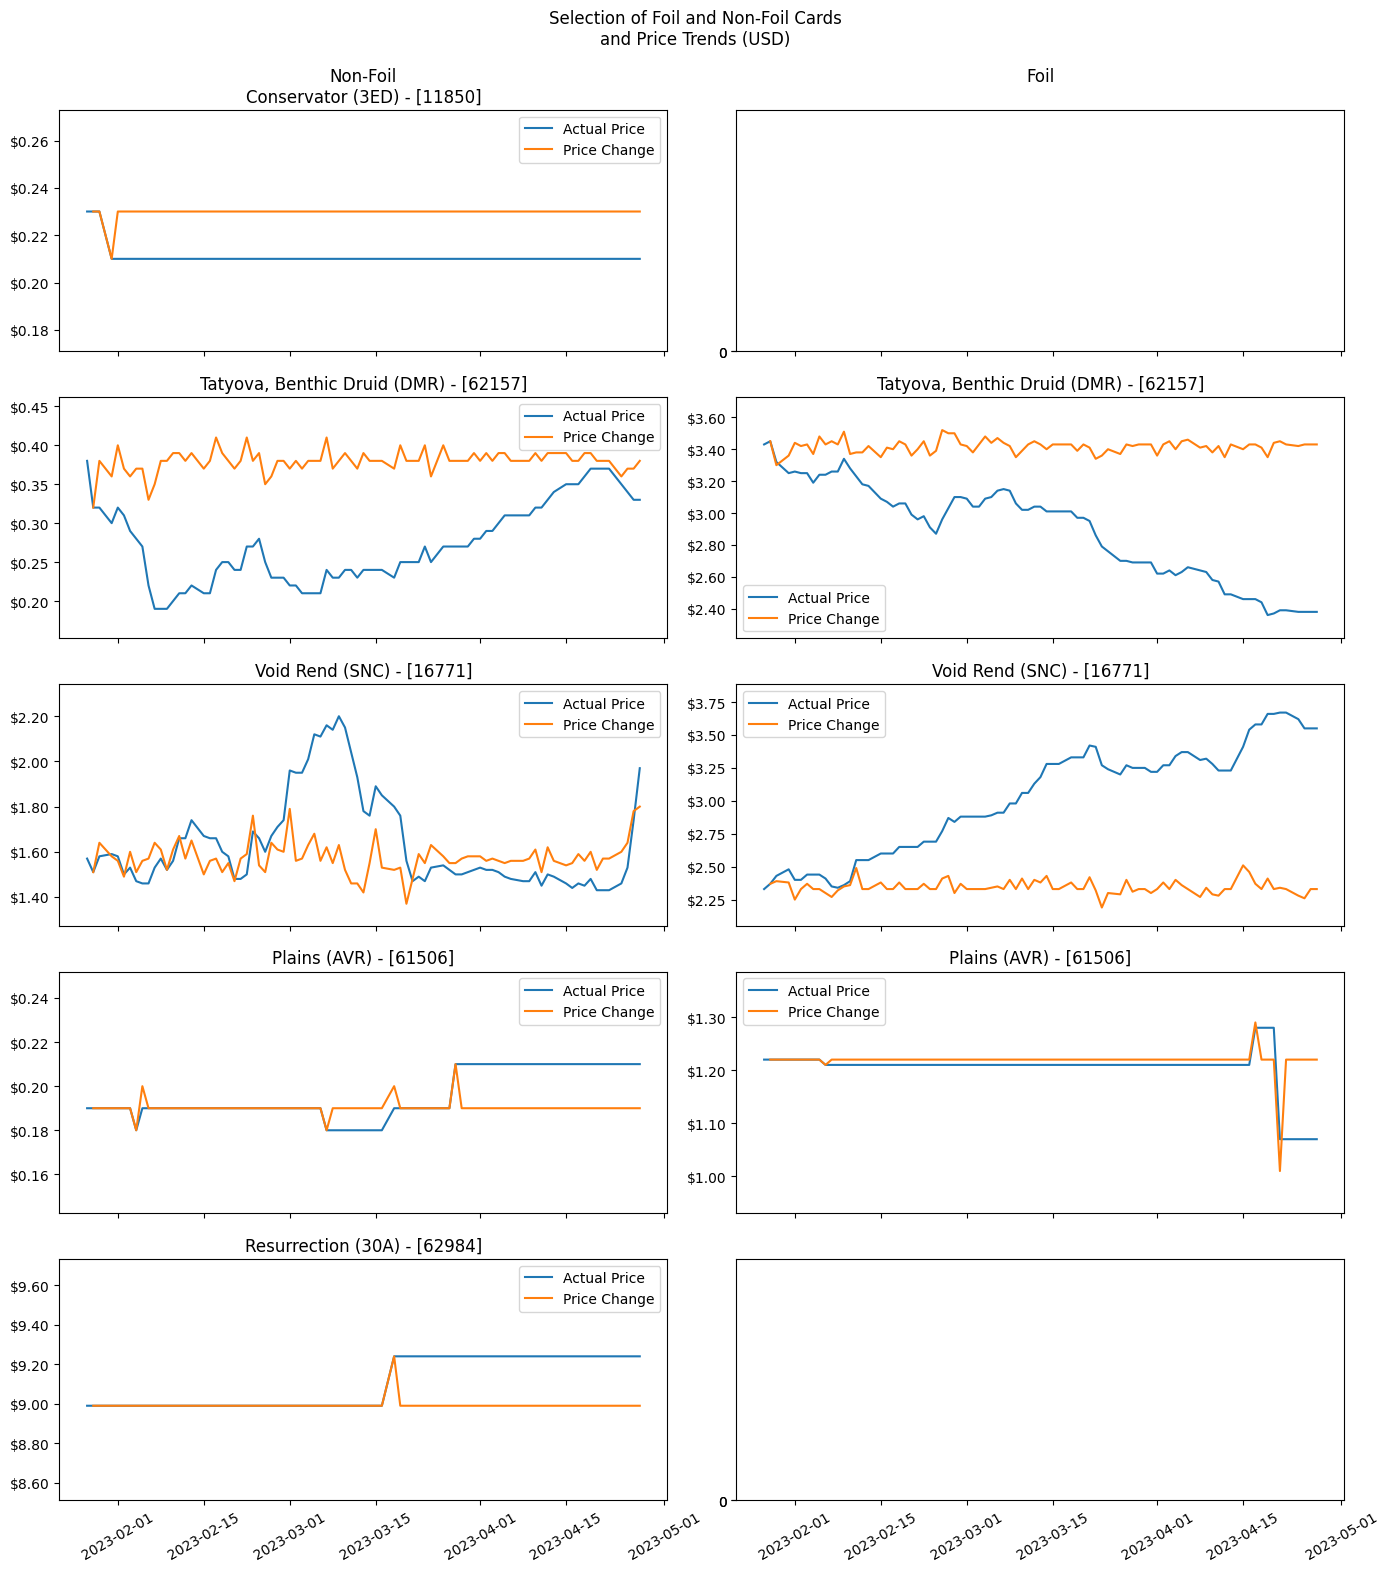

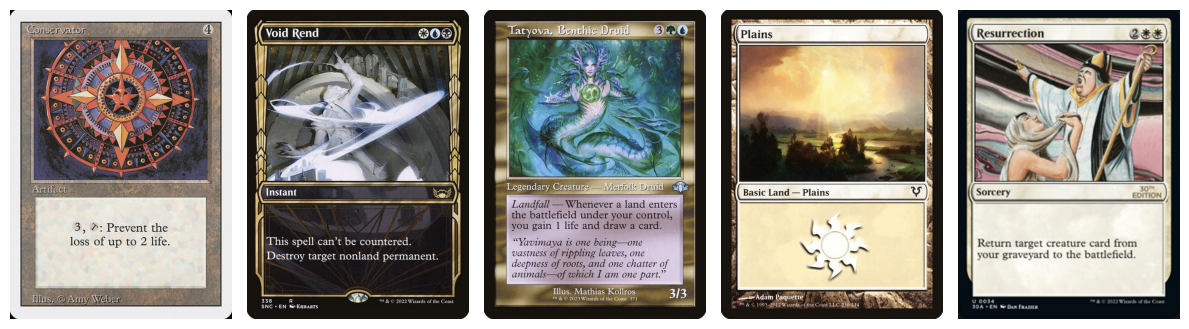

In [57]:
card_list = None
n_cards = 5

testing_cards = card_sampler(
    cards_attached_prices,
    n_cards=n_cards,
    card_list=card_list
)

plot_card_trends(
    testing_cards,
    card_list=card_list,
    # ax_scale=1.7,
    ax_scale=3,
    n_cards=n_cards
)

image_uris = card_imager(
    testing_cards,
    card_list=card_list,
    img_size='png',
    width=240,
    n_cards=n_cards,
    # hplot=False
)
'';

Let's take a look at the randomly selected cards. Since
a random state isn't being set here, specifics can't
really exist in a markdown form here, but prices vary
between different types of prints, be they foil or
non-foil.

In [58]:
testing_cards

,index,id,oracle_id,tcgplayer_id,name,released_at,image_uris,mana_cost,cmc,type_line,...,full_art,textless,edhrec_rank,related_uris,promo_types,loyalty,produced_mana,variation_of,prices_normal,prices_foil
0,62984,f682509c-470e-4cee-9e48-2aaed4feeaba,837417d8-8260-486d-a3ed-3b5711eaf34a,448910.0,Resurrection,2022-11-28,{'small': 'https://cards.scryfall.io/small/fro...,{2}{W}{W},4.0,Sorcery,...,False,False,7110.0,{'tcgplayer_infinite_articles': 'https://infin...,NaN,NaN,NaN,NaN,"{'2023-01-27': 8.99, '2023-01-28': 8.99, '2023...",None
1,62157,f32efed1-73ed-49bc-a1e1-53520ddd5d43,0715e860-3b3b-4331-9718-207973e94fee,449618.0,"Tatyova, Benthic Druid",2023-01-13,{'small': 'https://cards.scryfall.io/small/fro...,{3}{G}{U},5.0,Legendary Creature — Merfolk Druid,...,False,False,518.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,[boosterfun],NaN,NaN,NaN,"{'2023-01-27': 0.38, '2023-01-28': 0.32, '2023...","{'2023-01-27': 3.43, '2023-01-28': 3.45, '2023..."
2,61506,f090db87-b7a9-4c88-a211-495b27ae37c9,bc71ebf6-2056-41f7-be35-b2e5c34afa99,58272.0,Plains,2012-05-04,{'small': 'https://cards.scryfall.io/small/fro...,,0.0,Basic Land — Plains,...,False,False,NaN,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,[W],NaN,"{'2023-01-27': 0.19, '2023-01-28': 0.19, '2023...","{'2023-01-27': 1.22, '2023-01-28': 1.22, '2023..."
3,16771,41f2392d-7b1d-4521-b940-5ef44c464813,713f16db-95ec-479e-a48c-7a69f7668d7f,268828.0,Void Rend,2022-04-29,{'small': 'https://cards.scryfall.io/small/fro...,{W}{U}{B},3.0,Instant,...,False,False,1066.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,[boosterfun],NaN,NaN,NaN,"{'2023-01-27': 1.57, '2023-01-28': 1.51, '2023...","{'2023-01-27': 2.33, '2023-01-28': 2.37, '2023..."
4,11850,2e7d8bc5-9d87-43e3-9b81-311d01fdf0e5,1940e56d-0972-4ca4-946c-bbd42dde1dcb,1368.0,Conservator,1994-04-01,{'small': 'https://cards.scryfall.io/small/fro...,{4},4.0,Artifact,...,False,False,24281.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN,"{'2023-01-27': 0.23, '2023-01-28': 0.23, '2023...",None


Because we'll be investigating cards based on what they
do, we'll need to make one primary change - a lot of
cards will have an effect that is self-referential.
Basically, this would mean that a card would have an
effect that has its own name as part of the effect.
Since we'll be using NLP to analyze these cards, we
can't really rely on this to create consistent and
effective abilities for us to analyze.

One common solution to this in MtG search systems is to
replace the name of the card with the text "CARDNAME".
We can go ahead and do this here before saving it all
off to a more simplified data set for the next steps.

In [59]:
testing_cards['oracle_text'] = testing_cards.apply(synthesize_names,axis=1)
testing_cards[['oracle_text']]

,oracle_text
0,Return target creature card from your graveyar...
1,Landfall — Whenever a land enters the battlefi...
2,({T}: Add {W}.)
3,This spell can't be countered.\nDestroy target...
4,"{3}, {T}: Prevent the next 2 damage that would..."


In [60]:
testing_cards['oracle_text'].iloc[0]

'Return target creature card from your graveyard to the battlefield.'

We can go ahead and run these steps on the full data
frame and then export that as a file for us to use
in our next steps without having to run through all of
the same processes every time. The last thing we'll
want to do is create 90-day median columns for the
prices as a last step.

In [61]:
cards_attached_prices[cards_attached_prices['name'].str.contains('//')][['name','oracle_text']]

,name,oracle_text
57,Consecrate // Consume,NaN
140,Warrant // Warden,NaN
160,Bind // Liberate,NaN
162,"Nissa, Vastwood Seer // Nissa, Sage Animist",NaN
351,Skyclave Cleric // Skyclave Basilica,NaN
...,...,...
65255,"Dorothea, Vengeful Victim // Dorothea's Retrib...",NaN
65287,Armed // Dangerous,NaN
65314,Bonecrusher Giant // Stomp,NaN
65321,Desperate Farmer // Depraved Harvester,NaN


First, it looks like all of our double-faced or
two-part cards have their oracle_text column as nulls.
This may be something that can be fixed in a later
revision, but it's a small part of the subset, so for
now we'll just drop those.

Let's make sure that there aren't any other nulls in
our oracle_text column.

In [62]:
cards_attached_prices['oracle_text'].isna().sum()

1053

It looks like all of our nulls are captured in that
prior set, so once we take care of those - we can do
our name substitution on the rest of the data frame.

In [63]:
cards_attached_prices.dropna(subset='oracle_text',inplace=True)

In [64]:
cards_attached_prices['oracle_text'] = \
    cards_attached_prices.apply(
        synthesize_names,axis=1
    )

As a last step before outputting this to our simplified
file, we'll go ahead and pull in the 90-day median
prices as a singular item.

In [65]:
def regularize(x):
    if x==None:
        return None
    else:
        return np.median(list(x.values()))

In [66]:
cards_attached_prices['median_normal'] = \
    cards_attached_prices['prices_normal'].apply(regularize)

cards_attached_prices['median_foil'] = \
    cards_attached_prices['prices_foil'].apply(regularize)

Here, we can finally export the data to a new file
so that we can move on to the next step.

In [67]:
cards_attached_prices.to_parquet(
    './data/simplified_cards.parquet',
    index=False
)

In [100]:
# cards_attached_prices.to_csv(
#     './data/simplified_cards.csv',
#     index=False
# )